In [1]:
import pandas as pd
import datetime
import pandas_datareader.data as web
from pandas import Series, DataFrame


start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2017, 1, 11)

df = web.DataReader("SRE", 'yahoo', start, end)
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2017-01-06,103.160004,101.209999,101.449997,102.919998,934600.0,95.343346
2017-01-09,103.629997,101.279999,102.930000,101.379997,1005100.0,93.916710
2017-01-10,101.699997,100.089996,101.040001,101.059998,929300.0,93.620262
2017-01-11,102.519997,100.800003,100.919998,102.129997,1469200.0,94.611504
2017-01-12,102.900002,101.279999,102.139999,101.839996,806800.0,94.342850


In [2]:
close_px = df['Adj Close']
mavg = close_px.rolling(window=100).mean()

In [3]:
mavg

Date
2010-01-04          NaN
2010-01-05          NaN
2010-01-06          NaN
2010-01-07          NaN
2010-01-08          NaN
2010-01-11          NaN
2010-01-12          NaN
2010-01-13          NaN
2010-01-14          NaN
2010-01-15          NaN
2010-01-19          NaN
2010-01-20          NaN
2010-01-21          NaN
2010-01-22          NaN
2010-01-25          NaN
2010-01-26          NaN
2010-01-27          NaN
2010-01-28          NaN
2010-01-29          NaN
2010-02-01          NaN
2010-02-02          NaN
2010-02-03          NaN
2010-02-04          NaN
2010-02-05          NaN
2010-02-08          NaN
2010-02-09          NaN
2010-02-10          NaN
2010-02-11          NaN
2010-02-12          NaN
2010-02-16          NaN
                ...    
2016-11-30    96.840970
2016-12-01    96.720555
2016-12-02    96.596796
2016-12-05    96.473889
2016-12-06    96.349779
2016-12-07    96.233392
2016-12-08    96.123400
2016-12-09    96.026719
2016-12-12    95.941416
2016-12-13    95.858551
2016-12-14 

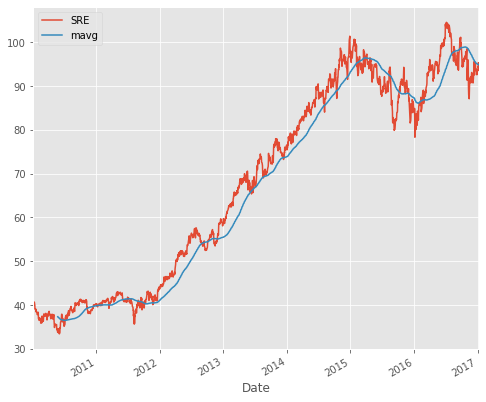

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

# Adjusting the size of matplotlib
import matplotlib as mpl
mpl.rc('figure', figsize=(8, 7))
mpl.__version__

# Adjusting the style of matplotlib
style.use('ggplot')

close_px.plot(label='SRE')
mavg.plot(label='mavg')
plt.legend()

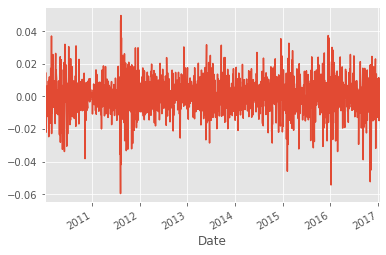

In [5]:
rets = close_px / close_px.shift(1) - 1
rets.plot(label='return')

In [6]:
dfreg = df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (df['High']-df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close']-df['Open']) / df['Open'] * 100.0

In [8]:
import math
import numpy as np
from sklearn import preprocessing
# Drop missing value
dfreg.fillna(value=-99999, inplace=True)
# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg)))
# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))
# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)
# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]
# Separate label and identify it as y
y = np.array(dfreg['label'])
y = y[:-forecast_out]

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import train_test_split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)
# Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, y_train)

# Quadratic Regression 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=3, include_bias=True,
                                    interaction_only=False, order='C')),
                ('ridge',
                 Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)

In [14]:
# KNN Regression
clfknn = KNeighborsRegressor(n_neighbors=2)
clfknn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                    weights='uniform')

In [17]:
confidencereg = clfreg.score(X_test, y_test)
confidencepoly2 = clfpoly2.score(X_test,y_test)
confidencepoly3 = clfpoly3.score(X_test,y_test)
confidenceknn = clfknn.score(X_test, y_test)

In [18]:
confidencereg
confidencepoly2
confidencepoly3
confidenceknn 

0.9636871643759927

In [21]:
forecast_set = clfreg.predict(X_lately)
dfreg['Forecast'] = np.nan

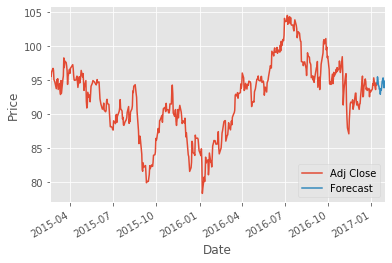

In [22]:
last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]
dfreg['Adj Close'].tail(500).plot()
dfreg['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()